# Evaluation using CREPE and Gentle Forced Aligner

In [1]:
# Dependencies
!pip install librosa
!pip install tensorflow==2.6.0
!pip install keras==2.6.0
!pip install crepe
!pip install scipy --upgrade
!pip install h5py
!pip install dtw-python
!pip install mido

# Things used so far:
"""
CREPE - Deep Learning Pitch Detector
Gentle Forced Aligner - Forced Alignment
Mido - Reading MIDI Files
dtw-python - Dynamic Time Warping to join CREPE output with MIDI file
"""

# Imports
import os
import pickle
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import crepe
from scipy.io import wavfile
from mido import MidiFile
from dtw import *

Requirement already up-to-date: scipy in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.5.4)
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Configurables and Setup

In [2]:
# Combination methods for times from forced aligner and pitch detector
def cmb_average(fa_time, pd_time):
    if fa_time is None or np.isnan(fa_time):
        if pd_time is None or np.isnan(pd_time):
            raise(Exception('Both times are None, cannot combine'))
        return pd_time
    if pd_time is None or np.isnan(pd_time):
        return fa_time
    return (fa_time + pd_time) / 2

# Average, but fall back to pitch detector time if forced aligner is far off
def cmb_average_threshold(thresh):
    return lambda x,y : cmb_average_threshold_helper(x, y, thresh)
def cmb_average_threshold_helper(fa_time, pd_time, threshold):
    if fa_time is None or np.isnan(fa_time):
        if pd_time is None or np.isnan(pd_time):
            raise(Exception('Both times are None, cannot combine'))
        return pd_time
    if pd_time is None or np.isnan(pd_time):
        return fa_time

    # Fall back to pitch detector time
    if abs(fa_time - pd_time) > threshold:
        return pd_time
    return (fa_time + pd_time) / 2

# Same as cmb_average, but allow both to be None/NaN
def cmb_average_lenient(time1, time2):
    if time1 is None or np.isnan(time1):
        if time2 is None or np.isnan(time2):
            return np.nan
        return time2
    if time2 is None or np.isnan(time2):
        return time1
    return (time1 + time2) / 2

In [3]:
# Configurables
# Data paths
data_path = 'data/test/CSD/wav/converted'
midi_path = 'data/test/CSD/mid'
lyric_note_path = 'data/test/CSD/lyric_mid'
ref_alignment_path = 'data/test/CSD/csv'
align_path = 'out/align'
pitch_path = 'out/pitch'

# Meta-options
num_files = 6 # How many data points to evaluate on? (Set to -1 or None to evaluate on all available files)
skip_files = ['en002a', 'en002b'] # Forced aligner output is completely off because of "Gloria" being almost 10 seconds long 6 times in the song

# Forced aligner options
max_word_length = 2 # Maximum length of a given word, in seconds, for forced aligner

# Audio options
midi_stretch = 50 # For convenience of DTW viewing, stretch each note by this many times (1 for no stretching)
# Prefer false, but it seems to mess up plotting of the alignment (however, it seems to still be correct output-wise? idk why only the plot is messed up)
use_frequency = True # If true, will use raw frequencies (e.g. 440 Hz) rather than note values (i.e. MIDI values, where A4 = 69 and Bb4 = 70).
pd_offset = 0.005 # Offset for pitch detector times (using 0.005 for now because the increments are 0, 0.01, 0.02 so we will just use the middle of each time period)

# DTW options
start_end_constraint = True # Whether the pitch detector alignment forces first word to start at 0 seconds and last word to end at end of file. Note that if this is True, the pitch detector's output will be ignored for the start of the first word and end of last word

# Evaluation
misalign_threshold = 0.5 # Threshold at which a matching will be considered a misalignment
threshold = 1.5 # Threshold (in seconds) of how different forced aligner and pitch detector times can be before just using pitch detector (for when forced aligner is very off)
combine_func = cmb_average_threshold(threshold) # Method to combine forced aligner and pitch detector times
start_end_combine_func = cmb_average_lenient # Method to combine start and end times of a word for simpler evaluation
skip_pd_edges = True # Whether to skip the pitch detector start time for first word and end time for last word

# Read in wavfiles
raw_filenames = []
wavfiles = [] # (sample rate, audio data)
i = 0
for filename in os.listdir(data_path):
    if filename.endswith(".wav"):
        # print(os.path.join(data_path, filename))
        raw_filenames.append(filename[:-4])
        wavfiles.append(wavfile.read(os.path.join(data_path, filename)))

        # limit # files
        i += 1
        if i >= num_files and num_files > 0:
            break

num_points = i # This should be the length of raw_filenames, as well as just about every other array relating to data
print('files:', raw_filenames)

# Read in MIDIs
midis = []
for filename in raw_filenames:
    midis.append(MidiFile(os.path.join(midi_path, filename + '.mid')))

# For each midi, convert to a more useful format
midi_references = []
midi_timings = []
for i, mid in enumerate(midis):
    track = mid.tracks[0]
    if len(mid.tracks) > 1:
        track = mid.tracks[1]

    # Simply keep track of note after note
    reference = []
    timing = []
    time = 0
    for msg in track:
        # For debugging
        # if i == 0:
        #     print(msg)
        if msg.type == 'note_on' or msg.type == 'note_off':
            freq = msg.note
            if use_frequency:
                # Prefer not to convert frequency because we probably want values linear in note value, not exponential in note value (as frequencies are)
                freq = 27.5 * 2 ** ((msg.note - 21) / 12) 
            time += msg.time
            # add to arrays
            for j in range(midi_stretch): 
                reference.append(freq)
                timing.append(time)
        elif msg.type != 'track_name' and msg.type != 'set_tempo' and msg.type != 'time_signature' and msg.type != 'end_of_track' and msg.type != 'key_signature':
            # encountered a message type that may mean something?
            print('[WARNING]', msg.type + ' encountered:', msg)

    midi_references.append(reference)
    midi_timings.append(timing)

# Fetch forced alignment info
word_starts = [] # Array of arrays of start times of words
word_ends = []
for filename in raw_filenames:
    # Get JSON object
    f = open(os.path.join(align_path, filename + '.json'),)
    data = json.load(f)
    
    # Iterate through the matches
    starts = []
    ends = []
    x = 0
    temp = 0
    for match_obj in data['words']:
        if match_obj['case'] == 'success':
            if match_obj['end'] - match_obj['start'] <= max_word_length:
                ends.append(match_obj['end'])
                starts.append(match_obj['start'])
            else:
                starts.append(None)
                ends.append(None)
            # match_obj['word'] gets the word from transcription
        else:
            # Match not found
            starts.append(None)
            ends.append(None)
    word_starts.append(starts)
    word_ends.append(ends)

# Fetch word to note (index) mappings
word_start_notes = [] # array of arrays mapping word i to the index of the note which marks its start
for filename in raw_filenames:
    csvfile = pd.read_csv(os.path.join(lyric_note_path, filename) + '.csv')
    word_start_notes.append(csvfile['start_note'].to_numpy())

# Fetch word to reference start/end time mappings
target_starts = []
target_ends = []
for filename in raw_filenames:
    csvfile = pd.read_csv(os.path.join(ref_alignment_path, filename) + '.csv')
    starts = []
    ends = []
    curr_idx = 0
    curr_word = csvfile['word'].iloc[curr_idx]

    # Iterate word by word to get start and end times by word instead of syllable (todo: split by syllables)
    while curr_idx < len(csvfile['word']):
        starts.append(csvfile['start'].iloc[curr_idx])
        while curr_idx < len(csvfile['word']) and csvfile['word'].iloc[curr_idx] == curr_word:
            curr_idx += 1
        ends.append(csvfile['end'].iloc[curr_idx - 1])
        # Update current word
        if curr_idx < len(csvfile['word']):
            curr_word = csvfile['word'].iloc[curr_idx]

    target_starts.append(np.array(starts))
    target_ends.append(np.array(ends))

files: ['en001a', 'en001b', 'en002a', 'en002b', 'en003a', 'en003b']
[WARNING] control_change encountered: control_change channel=0 control=121 value=0 time=0
[WARNING] program_change encountered: program_change channel=0 program=0 time=0
[WARNING] control_change encountered: control_change channel=0 control=7 value=100 time=0
[WARNING] control_change encountered: control_change channel=0 control=10 value=64 time=0
[WARNING] control_change encountered: control_change channel=0 control=91 value=0 time=0
[WARNING] control_change encountered: control_change channel=0 control=93 value=0 time=0
[WARNING] midi_port encountered: MetaMessage('midi_port', port=0, time=0)
[WARNING] control_change encountered: control_change channel=0 control=121 value=0 time=0
[WARNING] program_change encountered: program_change channel=0 program=0 time=0
[WARNING] control_change encountered: control_change channel=0 control=7 value=100 time=0
[WARNING] control_change encountered: control_change channel=0 control

## Running and Loading Predictions

In [8]:
# Run/load crepe predictions
def save_obj(filename, objs):
    with open(filename, 'wb') as outp:
        for obj in objs:
            pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def read_obj(filename, num_to_read):
    objs = []
    with open(filename, 'rb') as inp:
        for i in range(num_to_read):
            objs.append(pickle.load(inp))
        return objs

times = []
frequencies = []
confidences = []
activations = []
# Run/load crepe predictions
for i, file_info in enumerate(wavfiles):
    filename = os.path.join(pitch_path, raw_filenames[i] + '.pkl')
    if os.path.exists(filename):
        # Read cached prediction outputs
        arr = read_obj(filename, 4)
        time = arr[0]
        frequency = arr[1]
        confidence = arr[2]
        activation = arr[3]
    else:
        # Run prediction and save output
        sr = file_info[0]
        audio = file_info[1]
        time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)
        save_obj(filename, [time, frequency, confidence, activation])
    
    # freq = 27.5 * 2 ** ((msg.note - 21) / 12) 
    # Convert frequency back to note -> note = 12 * log_2(freq / 27.5) + 21
    if not use_frequency:
        for idx in range(len(frequency)):
            frequency[idx] = 12 * np.log2(frequency[idx] / 27.5) + 21
            if not frequency[idx] >= 0:
                print(frequency[idx])

    times.append(time)
    frequencies.append(frequency)
    confidences.append(confidence)
    activations.append(activation)

    # print(time, frequency, confidence, activation)

[0.000e+00 1.000e-02 2.000e-02 ... 6.478e+01 6.479e+01 6.480e+01] [32.97224247 32.57189768 32.4065771  ... 49.04862956 49.01639921
 49.06320917] [0.01889071 0.06190223 0.03802142 ... 0.04450408 0.03986016 0.0235799 ] [[0.00676242 0.0121406  0.01553246 ... 0.0035986  0.00391659 0.00547093]
 [0.00217712 0.00300938 0.00371149 ... 0.00677952 0.00794712 0.01024583]
 [0.00175115 0.00139049 0.00128102 ... 0.00202459 0.00221089 0.0028753 ]
 ...
 [0.00218505 0.00209308 0.00210947 ... 0.03896302 0.03561017 0.03712952]
 [0.00166011 0.00190276 0.00217196 ... 0.03508133 0.03299692 0.03402016]
 [0.00074667 0.00084871 0.00113332 ... 0.01762247 0.02110183 0.0235799 ]]
364.2562114768226
[0.000e+00 1.000e-02 2.000e-02 ... 6.478e+01 6.479e+01 6.480e+01] [32.83772768 32.91416761 33.16306219 ... 49.54494696 49.61841633
 49.397034  ] [0.02067664 0.04698685 0.02665249 ... 0.02104345 0.05813247 0.08474353] [[0.00846186 0.01460171 0.0192658  ... 0.00286826 0.00313234 0.00589299]
 [0.01303652 0.02548152 0.03900

Running DTW on en001a (length of query, template: 6481, 8600)


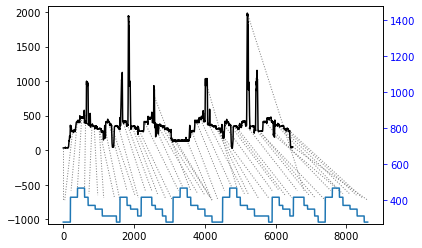

Running DTW on en001b (length of query, template: 6481, 8600)
Running DTW on en003a (length of query, template: 6261, 9800)
Running DTW on en003b (length of query, template: 6261, 9800)


In [5]:
# Run Dynamic Time Warping on each pair of predictions and reference MIDI
alignments = []
for i in range(len(times)):
    if raw_filenames[i] in skip_files:
        alignments.append(None) # fill in empty slot in array
        continue
        
    query = frequencies[i]
    template = midi_references[i]
    print('Running DTW on', raw_filenames[i], '(length of query, template:', str(len(query)) + ', ' + str(len(template)) + ')')
    ## Find the best match with the canonical recursion formula
    alignment = dtw(query, template, keep_internals=True, open_end=not start_end_constraint, open_begin=not start_end_constraint)
    alignments.append(alignment)

    # Plotting the matching
    if i == 0:
        off = -1000 if use_frequency else -50
        alignment.plot(type="twoway",offset=off)
        # plt.plot(reference)
        # plt.plot(alignment.index2,query[alignment.index1]) # query warped onto reference


## Evaluation

In [6]:
# Combine outputs
fa_errors = []
pd_errors = []
errors = []
fa_misalign = []
pd_misalign = []
misalign = []
for i in range(num_points):
    if raw_filenames[i] in skip_files:
        continue
    # Convert DTW output into start and end times of each word
    ref_lyric_note_alignment = word_start_notes[i]

    # (reference) Start/end times, indexed by word index
    ref_start_times = target_starts[i]
    ref_end_times = target_ends[i]
    num_words = len(ref_start_times) # number of words in sample
    # (forced alignment) Start/end times, indexed by word index
    fa_start_times = np.array(word_starts[i], dtype=np.float64)
    fa_end_times = np.array(word_ends[i], dtype=np.float64)
    # (reference) Start/end note indices (i.e. 0 if first note, 1 if second, etc), inclusive, indexed by word index
    ref_start_notes = []
    ref_end_notes = []
    for j in range(len(ref_lyric_note_alignment)):
        ref_start_notes.append(ref_lyric_note_alignment[j])
        ref_end_notes.append(ref_lyric_note_alignment[j+1] - 1 if j < len(ref_lyric_note_alignment) - 1 else -1) # -1 if last note
    # (pitch detector) alignment (index1 is indices in x, where x is query and y is reference)
    pd_alignment = alignments[i]
    # (pitch detector) times, indexed by query notes
    pd_times = times[i]
    query_indices = pd_alignment.index1
    reference_indices = pd_alignment.index2

    # Map alignment times to words
    curr_ref_idx = 0 # current index in reference_indices
    pd_start_times = [] # start times of each word, according to pitch detector
    pd_end_times = [] # end times of each word, according to pitch detector
    for word_idx in range(num_words):
        # Get the corresponding query index and plug it into the note times
        pd_start_times.append(pd_times[query_indices[curr_ref_idx]] + pd_offset)

        # go until the last note that is associated with this word (scale up by midi_stretch because we streteched each reference note by that much, scale up by 2 because each note appears twice)
        last_note = (ref_end_notes[word_idx] + 1) * 2 * midi_stretch - 1 if ref_end_notes[word_idx] >= 0 else reference_indices[-1]
        while curr_ref_idx < len(reference_indices) and reference_indices[curr_ref_idx] <= last_note:
            curr_ref_idx += 1

        # Get the corresponding query index (one before where we stopped) and plug it into the note times
        pd_end_times.append(pd_times[query_indices[curr_ref_idx - 1]] + pd_offset)
    pd_start_times = np.array(pd_start_times)
    pd_end_times = np.array(pd_end_times)

    # Combine forced aligner and pitch detector times
    pred_start_times = np.array([combine_func(fa_start_times[j], pd_start_times[j]) for j in range(num_words)])
    pred_end_times = np.array([combine_func(fa_end_times[j], pd_end_times[j]) for j in range(num_words)])
    if start_end_constraint:
        if fa_start_times[0] is not None:
            pred_start_times[0] = fa_start_times[0]
        if fa_end_times[-1] is not None:
            pred_end_times[-1] = fa_end_times[-1]

    # Combined times ("average" of start and end times of each word)
    fa_cmb_times = np.array([start_end_combine_func(fa_start_times[j], fa_end_times[j]) for j in range(num_words)])
    pd_cmb_times = np.array([start_end_combine_func(pd_start_times[j], pd_end_times[j]) for j in range(num_words)])
    pred_cmb_times = np.array([start_end_combine_func(pred_start_times[j], pred_end_times[j]) for j in range(num_words)])
    ref_cmb_times = np.array([start_end_combine_func(ref_start_times[j], ref_end_times[j]) for j in range(num_words)])

    # Evaluate outputs!
    pd_residual_start_times = pd_start_times - ref_start_times
    pd_residual_end_times = pd_end_times - ref_end_times
    fa_residual_start_times = fa_start_times - ref_start_times
    fa_residual_end_times = fa_end_times - ref_end_times
    residual_start_times = pred_start_times - ref_start_times
    residual_end_times = pred_end_times - ref_end_times
    # plt.plot(residual_start_times)
    # plt.plot(pd_residual_start_times)
    # plt.plot(fa_residual_start_times)
    fa_residual_nans = np.count_nonzero(np.isnan(fa_residual_start_times))
    pd_residual_nans = np.count_nonzero(np.isnan(pd_residual_start_times))
    print('===============================================================================')
    print('Results for file', raw_filenames[i])
    print('===============================================================================')
    if fa_residual_nans > 0:
        print('[WARNING] There are', fa_residual_nans, 'NaNs in forced aligner output out of', num_words, 'total')
        if fa_residual_nans > num_words / 4:
            print('[WARNING] Omitting due to > 25% missed forced alignment matches')
            continue
    if pd_residual_nans > 0:
        print('[WARNING] There are', pd_residual_nans, 'NaNs in pitch detector output out of', num_words, 'total')
        if pd_residual_nans > num_words / 4:
            print('[WARNING] Omitting due to > 25% pitch detector matches')
            continue
    print('Average forced aligner error (start):', np.nanmean(np.abs(fa_residual_start_times)))
    print('Average forced aligner error (end):', np.nanmean(np.abs(fa_residual_end_times)))
    print('Average pitch detector error (start):', np.nanmean(np.abs(pd_residual_start_times)))
    print('Average pitch detector error (end):', np.nanmean(np.abs(pd_residual_end_times)))
    print('Average combined error (start):', np.nanmean(np.abs(residual_start_times)))
    print('Average combined error (end):', np.nanmean(np.abs(residual_end_times)))

    pd_residual_cmb_times = pd_cmb_times - ref_cmb_times
    fa_residual_cmb_times = fa_cmb_times - ref_cmb_times
    # plt.plot(fa_residual_cmb_times)
    # print(np.argmax(fa_residual_cmb_times))
    # plt.title(raw_filenames[i])
    # plt.show()
    residual_cmb_times = pred_cmb_times - ref_cmb_times

    # Append errors
    fa_error = np.nanmean(np.abs(fa_residual_cmb_times))
    fa_errors.append(fa_error)
    pd_error = np.nanmean(np.abs(pd_residual_cmb_times))
    pd_errors.append(pd_error)
    error = np.nanmean(np.abs(residual_cmb_times))
    errors.append(error)

    # Append misalignment rates
    fa_misalign_count = 1 - np.count_nonzero(np.less(np.abs(fa_residual_cmb_times), misalign_threshold)) / num_words
    fa_misalign.append(fa_misalign_count)
    pd_misalign_count = 1 - np.count_nonzero(np.less(np.abs(pd_residual_cmb_times), misalign_threshold)) / num_words
    pd_misalign.append(pd_misalign_count)
    misalign_count = 1 - np.count_nonzero(np.less(np.abs(residual_cmb_times), misalign_threshold)) / num_words
    misalign.append(misalign_count)

    # Print overall info
    print('Average forced aligner error (overall):', fa_error)
    print('Forced aligner misalignment rate:', fa_misalign_count)
    print('Average pitch detector error (overall):', pd_error)
    print('Pitch detector misalignment rate:', pd_misalign_count)
    print('Average combined error (overall):', error)
    print('Overall misalignment rate:', misalign_count)
    # plt.plot(residual_cmb_times)
    # plt.title(raw_filenames[i])
    # plt.show()

fa_errors = np.array(fa_errors)
pd_errors = np.array(pd_errors)
errors = np.array(errors)

Results for file en001a
[WARNING] There are 6 NaNs in forced aligner output out of 81 total
Average forced aligner error (start): 0.2032534266666671
Average forced aligner error (end): 0.28420942666666654
Average pitch detector error (start): 0.3351604938271601
Average pitch detector error (end): 0.4196604938271606
Average combined error (start): 0.22460496913580236
Average combined error (end): 0.324998783950617
Average forced aligner error (overall): 0.23094739999999964
Forced aligner misalignment rate: 0.18518518518518523
Average pitch detector error (overall): 0.3282611111111109
Pitch detector misalignment rate: 0.19753086419753085
Average combined error (overall): 0.23284259259259277
Overall misalignment rate: 0.07407407407407407
Results for file en001b
Average forced aligner error (start): 0.09997662962962972
Average forced aligner error (end): 0.11995055555555502
Average pitch detector error (start): 0.308117283950617
Average pitch detector error (end): 0.42053827160493856
Avera

In [7]:
# Aggregated results
print('Average overall error (ms):', round(np.mean(errors) * 1000, 2))
print('Average overall misalignment % (' + str(misalign_threshold) + ' seconds):', round(np.mean(misalign) * 100, 2))
print('Average forced aligner error (ms):', round(np.mean(fa_errors) * 1000, 2))
print('Average forced aligner misalignment % (' + str(misalign_threshold) + ' seconds):', round(np.mean(fa_misalign) * 100, 2))
print('Average pitch detector error (ms):', round(np.mean(pd_errors) * 1000, 2))
print('Average pitch detector misalignment % (' + str(misalign_threshold) + ' seconds):', round(np.mean(pd_misalign) * 100, 2))

Average overall error (ms): 231.13
Average overall misalignment % (0.5 seconds): 8.06
Average forced aligner error (ms): 313.26
Average forced aligner misalignment % (0.5 seconds): 20.18
Average pitch detector error (ms): 310.92
Average pitch detector misalignment % (0.5 seconds): 17.22
